In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from collections import defaultdict
import dill
from tqdm.notebook import tqdm
import lightgbm as lgb

# Load data

In [2]:
%%time
columns = ['timestamp', 'user_id', 'content_id', 'content_type_id', 'task_container_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train_df = pd.read_pickle('train/cv1_train.pickle')[columns]
valid_df = pd.read_pickle('train/cv1_valid.pickle')[columns]

print('train_df size: {}'.format(train_df.shape))
print('valid_df size: {}'.format(valid_df.shape))

train_df size: (98730332, 8)
valid_df size: (2500000, 8)
CPU times: user 2.06 s, sys: 6.42 s, total: 8.48 s
Wall time: 8.47 s


In [3]:
prior_question_elapsed_time_mean = train_df['prior_question_elapsed_time'].dropna().values.mean()
prior_question_elapsed_time_mean

25439.41

# Load user features

In [4]:
%%time
train_user_content_feats_df = pd.read_pickle('loop_features/train_user_content_feats_df_90M.pkl')
valid_user_content_feats_df = pd.read_pickle('loop_features/valid_user_content_feats_df_90M.pkl')

CPU times: user 332 ms, sys: 1.24 s, total: 1.58 s
Wall time: 1.57 s


In [5]:
%%time
train_rolling_stats_feats_df = pd.read_pickle('loop_features/train_rolling_stats_feats_df_90M.pkl')
valid_rolling_stats_feats_df = pd.read_pickle('loop_features/valid_rolling_stats_feats_df_90M.pkl')

CPU times: user 791 ms, sys: 3.16 s, total: 3.95 s
Wall time: 3.95 s


In [6]:
%%time
train_user_content_part_feats_df = pd.read_pickle('loop_features/train_user_content_part_feats_df_90M.pkl')
valid_user_content_part_feats_df = pd.read_pickle('loop_features/valid_user_content_part_feats_df_90M.pkl')

CPU times: user 769 ms, sys: 3.37 s, total: 4.14 s
Wall time: 4.14 s


In [7]:
%%time
train_user_content_bundle_feats_df = pd.read_pickle('loop_features/train_user_content_bundle_feats_df_90M.pkl')
valid_user_content_bundle_feats_df = pd.read_pickle('loop_features/valid_user_content_bundle_feats_df_90M.pkl')

CPU times: user 19.8 ms, sys: 112 ms, total: 132 ms
Wall time: 131 ms


In [8]:
%%time
train_user_attempts_feats_df = pd.read_pickle('loop_features/train_user_attempts_feats_df_90M.pkl')
valid_user_attempts_feats_df = pd.read_pickle('loop_features/valid_user_attempts_feats_df_90M.pkl')

CPU times: user 27.7 ms, sys: 107 ms, total: 135 ms
Wall time: 134 ms


In [9]:
%%time
train_user_lecture_feats_df = pd.read_pickle('loop_features/train_user_lecture_feats_df_90M.pkl')
valid_user_lecture_feats_df = pd.read_pickle('loop_features/valid_user_lecture_feats_df_90M.pkl')

CPU times: user 64.2 ms, sys: 201 ms, total: 265 ms
Wall time: 264 ms


In [10]:
%%time
train_user_lecture_part_feats_df = pd.read_pickle('loop_features/train_user_lecture_part_feats_df_90M.pkl')
valid_user_lecture_part_feats_df = pd.read_pickle('loop_features/valid_user_lecture_part_feats_df_90M.pkl')

CPU times: user 201 ms, sys: 722 ms, total: 923 ms
Wall time: 922 ms


In [11]:
%%time
train_user_lecture_type_feats_df = pd.read_pickle('loop_features/train_user_lecture_type_feats_df_90M.pkl')
valid_user_lecture_type_feats_df = pd.read_pickle('loop_features/valid_user_lecture_type_feats_df_90M.pkl')

CPU times: user 84.1 ms, sys: 308 ms, total: 392 ms
Wall time: 391 ms


In [12]:
%%time
train_user_elapsed_time_feats_df = pd.read_pickle('loop_features/train_user_elapsed_time_feats_df_90M.pkl')
valid_user_elapsed_time_feats_df = pd.read_pickle('loop_features/valid_user_elapsed_time_feats_df_90M.pkl')

CPU times: user 219 ms, sys: 829 ms, total: 1.05 s
Wall time: 1.05 s


In [13]:
%%time
train_user_explanation_feats_df = pd.read_pickle('loop_features/train_user_explanation_feats_df_90M.pkl')
valid_user_explanation_feats_df = pd.read_pickle('loop_features/valid_user_explanation_feats_df_90M.pkl')

CPU times: user 99.7 ms, sys: 423 ms, total: 523 ms
Wall time: 522 ms


In [14]:
%%time
train_user_task_feats_df = pd.read_pickle('loop_features/train_user_task_feats_df_90M.pkl')
valid_user_task_feats_df = pd.read_pickle('loop_features/valid_user_task_feats_df_90M.pkl')

CPU times: user 104 ms, sys: 549 ms, total: 653 ms
Wall time: 652 ms


In [15]:
%%time
train_user_timestamp_diffs_feats_df = pd.read_pickle('loop_features/train_user_timestamp_diffs_feats_df_90M.pkl')
valid_user_timestamp_diffs_feats_df = pd.read_pickle('loop_features/valid_user_timestamp_diffs_feats_df_90M.pkl')

CPU times: user 1.07 s, sys: 4.17 s, total: 5.24 s
Wall time: 5.24 s


# Merge user features

In [16]:
debug = False

if debug:
    train_df = train_df[-2000000:]
    valid_df = valid_df[:10000]
    train_tmp_df = train_df
    valid_tmp_df = valid_df
    train_size = 2000000
    valid_size = 10000
else:
    train_size = train_df.shape[0]
    valid_size = valid_df.shape[0]

In [17]:
def merge_df(df, user_feats_df):
    df = df[-train_size:]
    df = pd.concat([df.reset_index(drop=True), user_feats_df], axis=1)
    
    return df

In [18]:
%%time
train_df = merge_df(train_df, train_user_content_feats_df)
valid_df = merge_df(valid_df, valid_user_content_feats_df)

del train_user_content_feats_df, valid_user_content_feats_df
gc.collect()

CPU times: user 1.25 s, sys: 1.59 s, total: 2.83 s
Wall time: 2.83 s


0

In [19]:
%%time
train_df = merge_df(train_df, train_rolling_stats_feats_df)
valid_df = merge_df(valid_df, valid_rolling_stats_feats_df)

del train_rolling_stats_feats_df, valid_rolling_stats_feats_df
gc.collect()

CPU times: user 3.26 s, sys: 3.95 s, total: 7.21 s
Wall time: 7.22 s


0

In [20]:
%%time
train_df = merge_df(train_df, train_user_content_part_feats_df)
valid_df = merge_df(valid_df, valid_user_content_part_feats_df)

del train_user_content_part_feats_df, valid_user_content_part_feats_df
gc.collect()

CPU times: user 5.52 s, sys: 6.97 s, total: 12.5 s
Wall time: 12.5 s


0

In [21]:
%%time
train_df = merge_df(train_df, train_user_content_bundle_feats_df)
valid_df = merge_df(valid_df, valid_user_content_bundle_feats_df)

del train_user_content_bundle_feats_df, valid_user_content_bundle_feats_df
gc.collect()

CPU times: user 7.57 s, sys: 9.35 s, total: 16.9 s
Wall time: 16.9 s


0

In [22]:
%%time
train_df = merge_df(train_df, train_user_attempts_feats_df)
valid_df = merge_df(valid_df, valid_user_attempts_feats_df)

del train_user_attempts_feats_df, valid_user_attempts_feats_df
gc.collect()

CPU times: user 7.47 s, sys: 9.6 s, total: 17.1 s
Wall time: 17.1 s


0

In [23]:
%%time
train_df = merge_df(train_df, train_user_lecture_feats_df)
valid_df = merge_df(valid_df, valid_user_lecture_feats_df)

del train_user_lecture_feats_df, valid_user_lecture_feats_df
gc.collect()

CPU times: user 7.75 s, sys: 9.61 s, total: 17.4 s
Wall time: 17.4 s


0

In [24]:
%%time
train_df = merge_df(train_df, train_user_lecture_part_feats_df)
valid_df = merge_df(valid_df, valid_user_lecture_part_feats_df)

del train_user_lecture_part_feats_df, valid_user_lecture_part_feats_df
gc.collect()

CPU times: user 7.84 s, sys: 10.1 s, total: 18 s
Wall time: 18 s


0

In [25]:
%%time
train_df = merge_df(train_df, train_user_lecture_type_feats_df)
valid_df = merge_df(valid_df, valid_user_lecture_type_feats_df)

del train_user_lecture_type_feats_df, valid_user_lecture_type_feats_df
gc.collect()

CPU times: user 8.58 s, sys: 10.7 s, total: 19.3 s
Wall time: 19.3 s


0

In [26]:
%%time
train_df = merge_df(train_df, train_user_elapsed_time_feats_df)
valid_df = merge_df(valid_df, valid_user_elapsed_time_feats_df)

del train_user_elapsed_time_feats_df, valid_user_elapsed_time_feats_df
gc.collect()

CPU times: user 9.01 s, sys: 11.1 s, total: 20.1 s
Wall time: 20.1 s


0

In [27]:
%%time
train_df = merge_df(train_df, train_user_explanation_feats_df)
valid_df = merge_df(valid_df, valid_user_explanation_feats_df)

del train_user_explanation_feats_df, valid_user_explanation_feats_df
gc.collect()

CPU times: user 9.57 s, sys: 11.7 s, total: 21.3 s
Wall time: 21.3 s


0

In [28]:
%%time
train_df = merge_df(train_df, train_user_task_feats_df)
valid_df = merge_df(valid_df, valid_user_task_feats_df)

del train_user_task_feats_df, valid_user_task_feats_df
gc.collect()

CPU times: user 9.74 s, sys: 12.3 s, total: 22 s
Wall time: 22 s


0

In [29]:
%%time
train_df = merge_df(train_df, train_user_timestamp_diffs_feats_df)
valid_df = merge_df(valid_df, valid_user_timestamp_diffs_feats_df)

del train_user_timestamp_diffs_feats_df, valid_user_timestamp_diffs_feats_df
gc.collect()

CPU times: user 10.9 s, sys: 13.6 s, total: 24.5 s
Wall time: 24.5 s


0

# Load basic & general stats features

In [30]:
questions_df = pd.read_pickle('basic_&_general_stats_features/questions_df.pkl')

In [31]:
content_df = pd.read_pickle('basic_&_general_stats_features/content_df.pkl')

In [32]:
content_part_df = pd.read_pickle('basic_&_general_stats_features/content_part_df.pkl')

In [33]:
content_bundle_bins_df = pd.read_pickle('basic_&_general_stats_features/content_bundle_bins_df.pkl')

In [34]:
content_tags1_df = pd.read_pickle('basic_&_general_stats_features/content_tags1_df.pkl')

In [35]:
content_prior_explanation_df = pd.read_pickle('basic_&_general_stats_features/content_prior_explanation_df.pkl')

In [36]:
content_elapsed_time_df = pd.read_pickle('basic_&_general_stats_features/content_elapsed_time_df.pkl')

# Add other features

In [37]:
def add_other_features(df):
    df = df[df['content_type_id'] == 0].reset_index(drop=True)
    
    df = pd.concat(
        [df, questions_df.reindex(df['content_id']).reset_index(drop=True)],
        axis=1
    )
    df = pd.concat(
        [df, content_df.reindex(df['content_id']).reset_index(drop=True)],
        axis=1
    )
    df = pd.concat(
        [df, content_part_df.reindex(df['part']).reset_index(drop=True)],
        axis=1
    )
    df = pd.concat(
        [df, content_bundle_bins_df.reindex(df['bundle_user_count_bins']).reset_index(drop=True)],
        axis=1
    )
    df = pd.concat(
        [df, content_tags1_df.reindex(df['tags1']).reset_index(drop=True)],
        axis=1
    )
    # df = pd.merge(
    #     df,
    #     content_tags1_tags2_df,
    #     how='left',
    #     left_on=['tags1', 'tags2'],
    #     right_index=True
    # )
    df = pd.concat(
        [df, content_prior_explanation_df.reindex(df['content_id']).reset_index(drop=True)],
        axis=1
    )
    df = pd.concat(
        [df, content_elapsed_time_df.reindex(df['content_id']).reset_index(drop=True)],
        axis=1
    )
    # df = pd.concat(
    #     [df, content_community_df.reindex(df['community']).reset_index(drop=True)],
    #     axis=1
    # )
    
    df['timestamp_day'] = np.round(df['timestamp']/(1000*60*60*24))
    df['timestamp'] = df['timestamp']/(1000*60) 
    df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    df['prior_question_elapsed_time'] = df['prior_question_elapsed_time']/(1000*60)
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].fillna(False).astype(np.int8)
    
    df['answered_correctly_user_content_mean_hmean'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_mean'])
    df['answered_correctly_user_std'] = np.sqrt((df['lag1'] - df['answered_correctly_user_mean'])**2)
    df['answered_correctly_user_content_std_hmean'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_std'])
    
    df['answered_correctly_user_part_mean_hmean'] = (2 * df['answered_correctly_user_part_mean'] * df['answered_correctly_content_part_mean']) / (df['answered_correctly_user_part_mean'] + df['answered_correctly_content_part_mean'])
    # df['answered_correctly_user_part_std_hmean'] = (2 * df['answered_correctly_user_part_std'] * df['answered_correctly_content_part_std']) / (df['answered_correctly_user_part_std'] + df['answered_correctly_content_part_std'])
    # df['answered_correctly_user_part_mean_hmean2'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_part_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_part_mean'])
    # df['answered_correctly_user_part_std_hmean2'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_part_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_part_std'])
    
    df['answered_correctly_user_bundle_mean_hmean'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_bundle_count_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_bundle_count_mean'])
    df['answered_correctly_user_bundle_std_hmean'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_bundle_count_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_bundle_count_std'])

    df['lecture_user_percent'] = df['lecture_user_count'] / (df['answered_user_count'] + df['lecture_user_count'])
    df['lecture_user_percent'].fillna(0, inplace=True)

    df['prior_elapsed_time_mean'] = df['prior_elapsed_time_sum'] / df['answered_user_count']
    df['prior_elapsed_time_mean'].fillna(0, inplace=True)

    df['prior_explanation_mean'] = df['prior_explanation_sum'] / df['answered_user_count']
    df['prior_explanation_mean'].fillna(0, inplace=True)

    df['answered_correctly_rolling5_content_mean_hmean'] = (2 * df['rolling5_mean'] * df['answered_correctly_content_mean']) / (df['rolling5_mean'] + df['answered_correctly_content_mean'])
    df['answered_correctly_rolling5_content_std_hmean'] = (2 * df['rolling5_std'] * df['answered_correctly_content_std']) / (df['rolling5_std'] + df['answered_correctly_content_std'])
    df['answered_correctly_rolling15_content_mean_hmean'] = (2 * df['rolling15_mean'] * df['answered_correctly_content_mean']) / (df['rolling15_mean'] + df['answered_correctly_content_mean'])
    df['answered_correctly_rolling15_content_std_hmean'] = (2 * df['rolling15_std'] * df['answered_correctly_content_std']) / (df['rolling15_std'] + df['answered_correctly_content_std'])
    df['answered_correctly_rolling30_content_mean_hmean'] = (2 * df['rolling30_mean'] * df['answered_correctly_content_mean']) / (df['rolling30_mean'] + df['answered_correctly_content_mean'])
    df['answered_correctly_rolling30_content_std_hmean'] = (2 * df['rolling30_std'] * df['answered_correctly_content_std']) / (df['rolling30_std'] + df['answered_correctly_content_std'])
    
    df['answered_correctly_user_tags1_mean_hmean'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_tags1_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_tags1_mean'])
    df['answered_correctly_user_tags1_std_hmean'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_tags1_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_tags1_std'])
    # df['answered_correctly_user_tags1_tags2_mean_hmean'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_tags1_tags2_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_tags1_tags2_mean'])
    # df['answered_correctly_user_tags1_tags2_std_hmean'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_tags1_tags2_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_tags1_tags2_std'])
    
    df['content_prior_explanation_wrong_mean_diff1'] = df['answered_correctly_user_mean'] - df['content_prior_explanation_wrong_mean']
    df['content_prior_explanation_correct_mean_diff1'] = df['answered_correctly_user_mean'] - df['content_prior_explanation_correct_mean']
    # df['content_prior_explanation_wrong_mean_diff2'] = df['rolling5_mean'] - df['content_prior_explanation_wrong_mean']
    # df['content_prior_explanation_correct_mean_diff2'] = df['rolling5_mean'] - df['content_prior_explanation_correct_mean']
    df['content_prior_explanation_wrong_mean_diff3'] = df['rolling30_mean'] - df['content_prior_explanation_wrong_mean']
    df['content_prior_explanation_correct_mean_diff3'] = df['rolling30_mean'] - df['content_prior_explanation_correct_mean']
    
    df['prior_question_elapsed_time_wrong_mean_diff1'] = df['prior_elapsed_time_mean'] - df['prior_question_elapsed_time_wrong_mean']
    df['prior_question_elapsed_time_correct_mean_diff1'] = df['prior_elapsed_time_mean'] - df['prior_question_elapsed_time_correct_mean']
    df['question_elapsed_time_wrong_mean_diff1'] = df['prior_elapsed_time_mean'] - df['question_elapsed_time_wrong_mean']
    df['question_elapsed_time_correct_mean_diff1'] = df['prior_elapsed_time_mean'] - df['question_elapsed_time_correct_mean']
    df['prior_question_elapsed_time_wrong_mean_diff2'] = df['timestamp_diff'] - df['prior_question_elapsed_time_wrong_mean']
    df['prior_question_elapsed_time_correct_mean_diff2'] = df['timestamp_diff'] - df['prior_question_elapsed_time_correct_mean']
    df['question_elapsed_time_wrong_mean_diff2'] = df['timestamp_diff'] - df['question_elapsed_time_wrong_mean']
    df['question_elapsed_time_correct_mean_diff2'] = df['timestamp_diff'] - df['question_elapsed_time_correct_mean']
    
    # df['answered_correctly_user_community_mean_hmean'] = (2 * df['answered_correctly_user_mean'] * df['answered_correctly_content_community_mean']) / (df['answered_correctly_user_mean'] + df['answered_correctly_content_community_mean'])
    # df['answered_correctly_user_community_std_hmean'] = (2 * df['answered_correctly_user_std'] * df['answered_correctly_content_community_std']) / (df['answered_correctly_user_std'] + df['answered_correctly_content_community_std'])

    return df

In [38]:
%%time
train_df = add_other_features(train_df)
valid_df = add_other_features(valid_df)

CPU times: user 30min 21s, sys: 34min 9s, total: 1h 4min 30s
Wall time: 1h 4min 31s


In [ ]:
train_df[train_df['user_id'] == 301133696]

In [ ]:
valid_df[valid_df['user_id'] == 301133696]

In [39]:
train_df.shape

(96817414, 118)

In [40]:
valid_df.shape

(2453886, 118)

# Model

In [41]:
train_df.columns.to_list()

['timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'answered_correctly',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'answered_user_count',
 'answered_correctly_user_sum',
 'answered_correctly_user_mean',
 'lag1',
 'lag2',
 'lag3',
 'lag4',
 'lag5',
 'rolling5_mean',
 'rolling5_std',
 'rolling15_mean',
 'rolling15_std',
 'rolling30_mean',
 'rolling30_std',
 'wrong_answered_user_count',
 'answered_user_part1_count',
 'answered_user_part2_count',
 'answered_user_part3_count',
 'answered_user_part4_count',
 'answered_user_part5_count',
 'answered_user_part6_count',
 'answered_user_part7_count',
 'answered_correctly_user_part1_sum',
 'answered_correctly_user_part2_sum',
 'answered_correctly_user_part3_sum',
 'answered_correctly_user_part4_sum',
 'answered_correctly_user_part5_sum',
 'answered_correctly_user_part6_sum',
 'answered_correctly_user_part7_sum',
 'answered_correctly_user_part_mean',
 'bundle_user_count_bins',
 'attempts',


In [42]:
features = [
    'timestamp',
     'user_id',
     'content_id',
     'task_container_id',
     'prior_question_elapsed_time',
     'prior_question_had_explanation',
     'answered_user_count',
     'answered_correctly_user_sum',
     'answered_correctly_user_mean',
     'lag1',
     'lag2',
     'lag3',
     'lag4',
     'lag5',
     'rolling5_mean',
     'rolling5_std',
     'rolling15_mean',
     'rolling15_std',
     'rolling30_mean',
     'rolling30_std',
     'wrong_answered_user_count',
     'answered_user_part1_count',
     'answered_user_part2_count',
     'answered_user_part3_count',
     'answered_user_part4_count',
     'answered_user_part5_count',
     'answered_user_part6_count',
     'answered_user_part7_count',
     'answered_correctly_user_part1_sum',
     'answered_correctly_user_part2_sum',
     'answered_correctly_user_part3_sum',
     'answered_correctly_user_part4_sum',
     'answered_correctly_user_part5_sum',
     'answered_correctly_user_part6_sum',
     'answered_correctly_user_part7_sum',
     'answered_correctly_user_part_mean',
     'bundle_user_count_bins',
     'attempts',
     'lecture_user_count',
     'lecture_user_part1_count',
     'lecture_user_part2_count',
     'lecture_user_part3_count',
     'lecture_user_part4_count',
     'lecture_user_part5_count',
     'lecture_user_part6_count',
     'lecture_user_part7_count',
     'lecture_user_concept_count',
     'lecture_user_solving_question_count',
     'lecture_user_intention_count',
     'prior_elapsed_time_sum',
     'prior_elapsed_time_diff',
     'prior_explanation_sum',
     'task_count',
     'task_content_number',
     'timestamp_lag1',
     'timestamp_lag2',
     'timestamp_lag3',
     'timestamp_lag4',
     'timestamp_lag5',
     'timestamp_diff',
     'timestamp_diff2',
     'timestamp_diff3',
     'timestamp_diff4',
     'timestamp_diff5',
     'bundle_id',
     'part',
     'tags_number',
     'tags1',
     'tags2',
     'tags3',
     'tags4',
     'community',
     'answered_correctly_content_mean',
     'answered_correctly_content_std',
     'answered_correctly_content_part_mean',
     'answered_correctly_content_part_std',
     'answered_correctly_content_bundle_count_mean',
     'answered_correctly_content_bundle_count_std',
     'answered_correctly_content_tags1_mean',
     'answered_correctly_content_tags1_std',
     'content_prior_explanation_wrong_mean',
     'content_prior_explanation_correct_mean',
     'prior_question_elapsed_time_wrong_mean',
     'prior_question_elapsed_time_correct_mean',
     'question_elapsed_time_wrong_mean',
     'question_elapsed_time_correct_mean',
     'timestamp_day',
     'answered_correctly_user_content_mean_hmean',
     'answered_correctly_user_std',
     'answered_correctly_user_content_std_hmean',
     'answered_correctly_user_part_mean_hmean',
     'answered_correctly_user_bundle_mean_hmean',
     'answered_correctly_user_bundle_std_hmean',
     'lecture_user_percent',
     'prior_elapsed_time_mean',
     'prior_explanation_mean',
     'answered_correctly_rolling5_content_mean_hmean',
     'answered_correctly_rolling5_content_std_hmean',
     'answered_correctly_rolling15_content_mean_hmean',
     'answered_correctly_rolling15_content_std_hmean',
     'answered_correctly_rolling30_content_mean_hmean',
     'answered_correctly_rolling30_content_std_hmean',
     'answered_correctly_user_tags1_mean_hmean',
     'answered_correctly_user_tags1_std_hmean',
     'content_prior_explanation_wrong_mean_diff1',
     'content_prior_explanation_correct_mean_diff1',
     'content_prior_explanation_wrong_mean_diff3',
     'content_prior_explanation_correct_mean_diff3',
     'prior_question_elapsed_time_wrong_mean_diff1',
     'prior_question_elapsed_time_correct_mean_diff1',
     'question_elapsed_time_wrong_mean_diff1',
     'question_elapsed_time_correct_mean_diff1',
     'prior_question_elapsed_time_wrong_mean_diff2',
     'prior_question_elapsed_time_correct_mean_diff2',
     'question_elapsed_time_wrong_mean_diff2',
     'question_elapsed_time_correct_mean_diff2'
]

# categorical_features = []

target = 'answered_correctly'

In [43]:
len(features)

116

In [44]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [45]:
%%time
train_df = reduce_mem_usage(train_df)
valid_df = reduce_mem_usage(valid_df)

Mem. usage decreased to 25576.04 Mb (47.1% reduction)
Mem. usage decreased to 645.90 Mb (47.3% reduction)
CPU times: user 1min 52s, sys: 56.2 s, total: 2min 48s
Wall time: 2min 48s


## Create lgbm datasets

In [46]:
y_train = train_df[target].values
y_valid = valid_df[target].values

In [47]:
%%time
N_ROWS = len(train_df)
N_COLS = len(features)

X_train = np.ndarray(shape=(N_ROWS, N_COLS), dtype=np.float32)
for idx, feature in enumerate(features):
    if train_df[feature].min() >= np.finfo(np.float32).max or train_df[feature].max() <= np.finfo(np.float16).min:
        X_train[:, idx] = train_df[feature].values.astype(np.float64)
    else:
        X_train[:, idx] = train_df[feature].values.astype(np.float32)
        
del train_df
gc.collect()

CPU times: user 4min 34s, sys: 32.6 s, total: 5min 7s
Wall time: 5min 7s


0

In [48]:
%%time
N_ROWS = len(valid_df)
N_COLS = len(features)

X_valid = np.ndarray(shape=(N_ROWS, N_COLS), dtype=np.float32)
for idx, feature in enumerate(features):
    if valid_df[feature].min() >= np.finfo(np.float32).max or valid_df[feature].max() <= np.finfo(np.float16).min:
        X_valid[:, idx] = valid_df[feature].values.astype(np.float64)
    else:
        X_valid[:, idx] = valid_df[feature].values.astype(np.float32)
        
del valid_df
gc.collect()

CPU times: user 6.9 s, sys: 281 ms, total: 7.18 s
Wall time: 7.18 s


0

In [49]:
%%time
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=features, free_raw_data=False) # categorical_feature=['part','prior_question_had_explanation'],
lgb_valid = lgb.Dataset(X_valid, label=y_valid, feature_name=features, free_raw_data=False) # categorical_feature=['part','prior_question_had_explanation'],

CPU times: user 9 µs, sys: 10 µs, total: 19 µs
Wall time: 22.4 µs


## Train

In [50]:
%%time
lgb_params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=10000,
    valid_sets= [lgb_train, lgb_valid],
    early_stopping_rounds=50,
    verbose_eval=50,
)

[LightGBM] [Info] Number of positive: 63669896, number of negative: 33147518
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 32.639302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61739
[LightGBM] [Info] Number of data points in the train set: 96817414, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657629 -> initscore=0.652744
[LightGBM] [Info] Start training from score 0.652744
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.769445	valid_1's auc: 0.772934
[100]	training's auc: 0.775006	valid_1's auc: 0.778223
[150]	training's auc: 0.777687	valid_1's auc: 0.780817
[200]	training's auc: 0.779263	valid_1's auc: 0.782362
[250]	training's auc: 0.780365	valid_1's auc: 0.783429
[300]	training's auc: 0.781247	valid_1's auc: 0.784269
[350]	training's auc: 0.781911	valid_1's auc: 0.784883
[400]	training's auc: 0.782438	valid_1's auc: 0.

[6900]	training's auc: 0.793313	valid_1's auc: 0.792751
[6950]	training's auc: 0.793352	valid_1's auc: 0.792765
[7000]	training's auc: 0.793381	valid_1's auc: 0.792771
[7050]	training's auc: 0.793423	valid_1's auc: 0.792788
[7100]	training's auc: 0.793462	valid_1's auc: 0.792802
[7150]	training's auc: 0.793496	valid_1's auc: 0.792812
[7200]	training's auc: 0.793535	valid_1's auc: 0.792828
[7250]	training's auc: 0.793569	valid_1's auc: 0.792837
[7300]	training's auc: 0.793605	valid_1's auc: 0.792848
[7350]	training's auc: 0.793639	valid_1's auc: 0.792857
[7400]	training's auc: 0.793678	valid_1's auc: 0.792872
[7450]	training's auc: 0.793715	valid_1's auc: 0.792879
[7500]	training's auc: 0.79375	valid_1's auc: 0.792886
[7550]	training's auc: 0.793784	valid_1's auc: 0.792892
[7600]	training's auc: 0.793817	valid_1's auc: 0.792901
[7650]	training's auc: 0.793854	valid_1's auc: 0.792911
[7700]	training's auc: 0.793896	valid_1's auc: 0.792927
[7750]	training's auc: 0.793938	valid_1's auc: 0.

In [51]:
model.save_model('models/20201228_model_90M.txt')

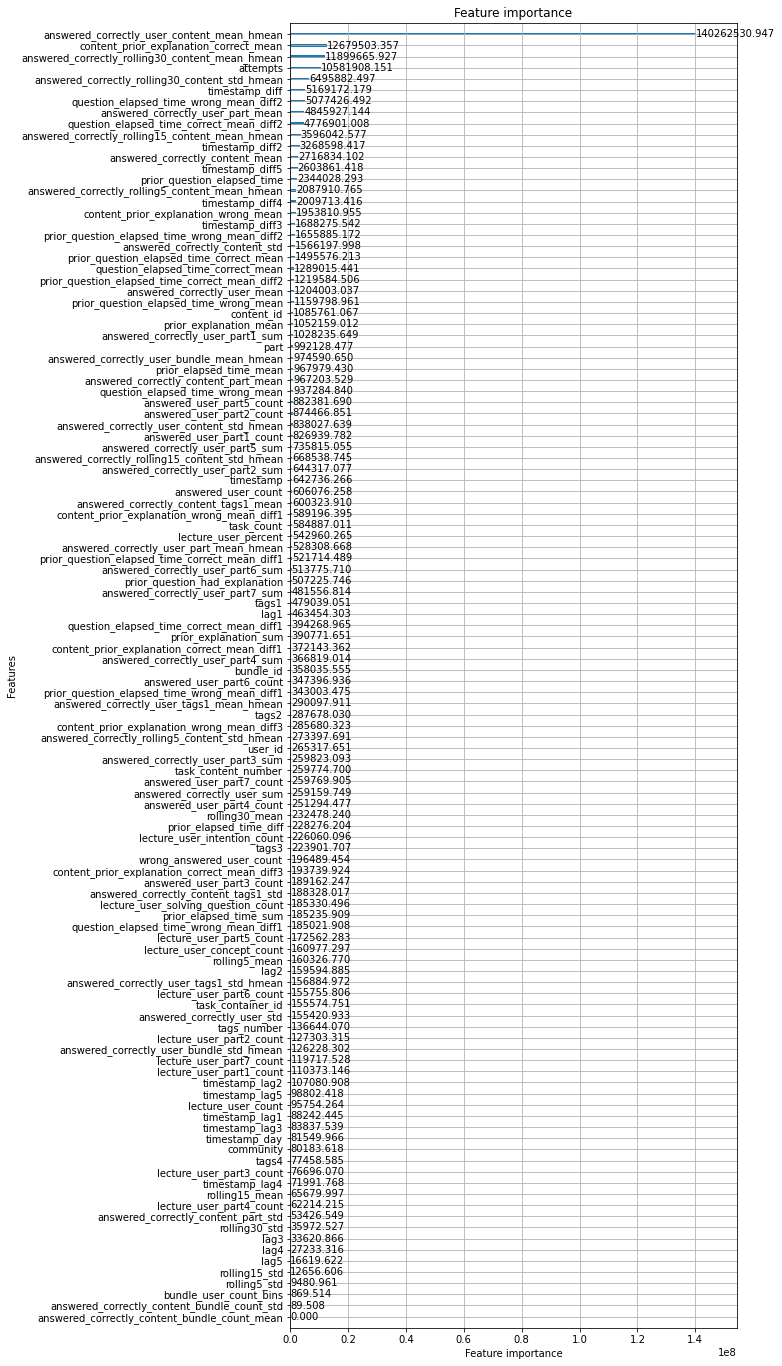

In [52]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 24), ignore_zero=False)
plt.show()